# IZMIR HOUSES RENT PRICES PREDICTION MODEL PREPROCESSING THE DATASET

---

**Initial** dataset is webscrapped from: https://www.hepsiemlak.com/izmir-kiralik, The selenium webdriver couldnt work on googlecoolab thats why the webscraping part is recorded in this repository https://github.com/mero468/HespiEmlak-WebScrapper

## CONNECT TO GOOGLE DRIVE TO REACH FILES UNDER A SPECIFIC FOLDER

In [199]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ADD IMPORTANT LIBRARIES

In [200]:
%pip install pandas numpy matplotlib scikit-learn lightgbm seaborn --quiet transformers trnlp

%pip install --upgrade sympy


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline

%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

## LOAD DATASET FROM DRIVE

In [201]:
df = pd.read_excel("/content/drive/MyDrive/listings.xlsx")
print(df.head())

                                                name  \
0  ÖZPA - BAHÇELİEVLER KEBABÇILARDA GİRİT LOKANTA...   
1               KARŞIYAKA MERKEZDE KİRALIK 2+1 DAİRE   
2                Göztepe'de boyalı 3+1 satılık daire   
3  URLA ATATÜRK MAHALLESİ'NDE KİRALIK 1+1 MÜSTAKİ...   
4        YAŞAR ÜNİVERSİTESİ KARŞISI 2+1 KLASİK DAİRE   

                                 location       price room_no area_m2  \
0  İzmir / Karabağlar / Bahçelievler Mah.  25.000\nTL   2 + 1   88 m²   
1          İzmir / Karşıyaka / Aksoy Mah.  25.000\nTL   2 + 1  100 m²   
2            İzmir / Konak / Göztepe Mah.  18.000\nTL   3 + 1  110 m²   
3             İzmir / Urla / Atatürk Mah.  25.000\nTL   1 + 1   45 m²   
4      İzmir / Bayraklı / Mansuroğlu Mah.  20.000\nTL   2 + 2  115 m²   

          age       floor        date  \
0  35 Yaşında      1. Kat  09-11-2024   
1  31 Yaşında      4. Kat  12-11-2024   
2  40 Yaşında      3. Kat  13-11-2024   
3   2 Yaşında  Bahçe Katı  26-10-2024   
4  42 Yaşında      

## INSPECT AND PREPARE OUR TABLE

The data has 14 columns, we will be pruning the amount of columns for our purposes. We will be removing the Name ,the date and the Link as they are not necessary and unprocessable and wont provide any descriminatory value.

In [202]:
columns_to_keep = [
    'location', 'price', 'room_no', 'area_m2', 'age', 'floor', 'furniture',
    'heating_type', 'fuel_type', 'monthly_fee'
]

# Select only the specified columns
df = df.loc[:, columns_to_keep]
df

,location,price,room_no,area_m2,age,floor,furniture,heating_type,fuel_type,monthly_fee
0,İzmir / Karabağlar / Bahçelievler Mah.,25.000\nTL,2 + 1,88 m²,35 Yaşında,1. Kat,Eşyalı Değil,Kombi,Doğalgaz,100 TL
1,İzmir / Karşıyaka / Aksoy Mah.,25.000\nTL,2 + 1,100 m²,31 Yaşında,4. Kat,Eşyalı Değil,Kombi,NaN,NaN
2,İzmir / Konak / Göztepe Mah.,18.000\nTL,3 + 1,110 m²,40 Yaşında,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,NaN
3,İzmir / Urla / Atatürk Mah.,25.000\nTL,1 + 1,45 m²,2 Yaşında,Bahçe Katı,Eşyalı,Kombi,NaN,NaN
4,İzmir / Bayraklı / Mansuroğlu Mah.,20.000\nTL,2 + 2,115 m²,42 Yaşında,2. Kat,NaN,Isıtma Yok,Elektrik,100 TL
...,...,...,...,...,...,...,...,...,...,...
9349,İzmir / Balçova / Korutürk Mah.,21.000\nTL,3 + 1,125 m²,28 Yaşında,3. Kat,Eşyalı Değil,Jeotermal Isıtma,NaN,150 TL
9350,İzmir / Bornova / Atatürk Mah.,19.000\nTL,2 + 1,120 m²,20 Yaşında,2. Kat,Eşyalı Değil,Kombi,Doğalgaz,NaN
9351,İzmir / Karşıyaka / Şemikler Mah.,35.000\nTL,4 + 1,226 m²,5 Yaşında,5. Kat,Eşyalı Değil,Merkezi (Pay Ölçer),NaN,250 TL
9352,İzmir / Menemen / İnönü Mah.,12.000\nTL,1 + 1,55 m²,Sıfır Bina,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,NaN


Now we clean up the most important feature price,area_m2 and create a new feature PRICE_PER_M2

In [203]:
# Ensure 'price' is treated as strings before cleaning
df['price'] = df['price'].astype(str)
df['price'] = (
    df['price']
    .str.replace('\nTL', '', regex=False)
    .str.replace('.', '', regex=False)  # Remove thousands separator without altering value
    .astype(int)
)
# Clean and convert 'monthly_fee' column, setting NaN values to 0
df['monthly_fee'] = df['monthly_fee'].astype(str)  # Ensure all values are strings
df['monthly_fee'] = (
    df['monthly_fee']
    .str.replace(' TL', '', regex=False)  # Remove ' TL'
    .str.replace('.', '', regex=False)    # Remove thousands separator
    .replace(['', 'nan'], '0')            # Replace empty strings and 'nan' with '0'
    .astype(float)                        # Convert to float or int as needed
    .fillna(0)                            # Ensure any remaining NaNs are set to 0
)
df['area_m2'] = (
    df['area_m2']
    .astype(str)                   # Ensure all values are strings
    .str.replace(' m²', '', regex=False)  # Remove the ' m²' suffix
    .str.replace(',', '', regex=False)   # Remove commas, if any
    .astype(float)                 # Convert to float
)

# Clean and convert 'deposit' column, setting NaN to '0'
# df['deposit'] = df['deposit'].astype(str)  # Ensure all values are strings
# df['deposit'] = (
#     df['deposit']
#     .str.replace(' TL', '', regex=False)  # Remove ' TL'
#     .str.replace('.', '', regex=False)    # Remove thousands separator
#     .replace(['', 'nan'], '0')            # Replace empty strings and 'nan' with '0'
#     .astype(float)                        # Convert to float or int as needed
#     .fillna(0)                            # Ensure any remaining NaNs are set to 0
# )

df

,location,price,room_no,area_m2,age,floor,furniture,heating_type,fuel_type,monthly_fee
0,İzmir / Karabağlar / Bahçelievler Mah.,25000,2 + 1,88.0,35 Yaşında,1. Kat,Eşyalı Değil,Kombi,Doğalgaz,100.0
1,İzmir / Karşıyaka / Aksoy Mah.,25000,2 + 1,100.0,31 Yaşında,4. Kat,Eşyalı Değil,Kombi,NaN,0.0
2,İzmir / Konak / Göztepe Mah.,18000,3 + 1,110.0,40 Yaşında,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0
3,İzmir / Urla / Atatürk Mah.,25000,1 + 1,45.0,2 Yaşında,Bahçe Katı,Eşyalı,Kombi,NaN,0.0
4,İzmir / Bayraklı / Mansuroğlu Mah.,20000,2 + 2,115.0,42 Yaşında,2. Kat,NaN,Isıtma Yok,Elektrik,100.0
...,...,...,...,...,...,...,...,...,...,...
9349,İzmir / Balçova / Korutürk Mah.,21000,3 + 1,125.0,28 Yaşında,3. Kat,Eşyalı Değil,Jeotermal Isıtma,NaN,150.0
9350,İzmir / Bornova / Atatürk Mah.,19000,2 + 1,120.0,20 Yaşında,2. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0
9351,İzmir / Karşıyaka / Şemikler Mah.,35000,4 + 1,226.0,5 Yaşında,5. Kat,Eşyalı Değil,Merkezi (Pay Ölçer),NaN,250.0
9352,İzmir / Menemen / İnönü Mah.,12000,1 + 1,55.0,Sıfır Bina,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0


Make age groups and floor groups for the building

In [204]:
# Ensure 'age' column is treated as strings before extraction
df['age'] = df['age'].astype(str)

# Extract numeric part of the 'age' column
df['age'] = df['age'].str.extract('(\d+)', expand=False).astype(float)

# Fill missing values in 'age' with the column mean (or median for robustness)
df['age'] = df['age'].fillna(df['age'].mean())

# Define function to categorize age
def categorize_age(age):
    try:
        if age <= 5:
            return 'New'
        elif age <= 15:
            return 'Moderate Age'
        elif age <= 30:
            return 'Old'
        else:
            return 'Very Old'
    except:
        return 'Unknown'

# Apply the function to create an 'AGE_GROUP' column
df['AGE_GROUP'] = df['age'].apply(categorize_age)

# Define a function to group floor values
def categorize_floor(floor):
    if 'Bahçe Katı' in floor or 'Zemin Kat' in floor or 'Giriş Kat' in floor:
        return 'Ground Floor'
    elif '1. Kat' in floor:
        return 'First Floor'
    elif 'Çatı Katı' in floor:
        return 'Top Floor'
    elif any(char.isdigit() for char in floor):  # Check if a numeric value exists in the floor string
        floor_number = int(''.join(filter(str.isdigit, floor)))
        if floor_number <= 5:
            return 'Low Floor'
        elif floor_number <= 10:
            return 'Mid Floor'
        else:
            return 'High Floor'
    else:
        return 'Unknown'

# Apply the function to categorize the floor column
df['floor'] = df['floor'].astype(str)
df['floor_group'] = df['floor'].apply(categorize_floor)

df

,location,price,room_no,area_m2,age,floor,furniture,heating_type,fuel_type,monthly_fee,AGE_GROUP,floor_group
0,İzmir / Karabağlar / Bahçelievler Mah.,25000,2 + 1,88.0,35.00000,1. Kat,Eşyalı Değil,Kombi,Doğalgaz,100.0,Very Old,First Floor
1,İzmir / Karşıyaka / Aksoy Mah.,25000,2 + 1,100.0,31.00000,4. Kat,Eşyalı Değil,Kombi,NaN,0.0,Very Old,Low Floor
2,İzmir / Konak / Göztepe Mah.,18000,3 + 1,110.0,40.00000,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Very Old,Low Floor
3,İzmir / Urla / Atatürk Mah.,25000,1 + 1,45.0,2.00000,Bahçe Katı,Eşyalı,Kombi,NaN,0.0,New,Ground Floor
4,İzmir / Bayraklı / Mansuroğlu Mah.,20000,2 + 2,115.0,42.00000,2. Kat,NaN,Isıtma Yok,Elektrik,100.0,Very Old,Low Floor
...,...,...,...,...,...,...,...,...,...,...,...,...
9349,İzmir / Balçova / Korutürk Mah.,21000,3 + 1,125.0,28.00000,3. Kat,Eşyalı Değil,Jeotermal Isıtma,NaN,150.0,Old,Low Floor
9350,İzmir / Bornova / Atatürk Mah.,19000,2 + 1,120.0,20.00000,2. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Old,Low Floor
9351,İzmir / Karşıyaka / Şemikler Mah.,35000,4 + 1,226.0,5.00000,5. Kat,Eşyalı Değil,Merkezi (Pay Ölçer),NaN,250.0,New,Low Floor
9352,İzmir / Menemen / İnönü Mah.,12000,1 + 1,55.0,16.84387,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Old,Low Floor


Divide the locations into City, District and Neighborhood

In [205]:
# Split the location into City, District, and Neighborhood
def split_location(location):
    try:
        parts = location.split(' / ')
        city = parts[0].strip() if len(parts) > 0 else 'Unknown'
        district = parts[1].strip() if len(parts) > 1 else 'Unknown'
        neighborhood = parts[2].strip() if len(parts) > 2 else 'Unknown'
        return pd.Series([city, district, neighborhood])
    except:
        return pd.Series(['Unknown', 'Unknown', 'Unknown'])

# Apply the function to create separate columns
df[['City', 'District', 'Neighborhood']] = df['location'].apply(split_location)
df = df.drop(columns=['City','location'])
df

,price,room_no,area_m2,age,floor,furniture,heating_type,fuel_type,monthly_fee,AGE_GROUP,floor_group,District,Neighborhood
0,25000,2 + 1,88.0,35.00000,1. Kat,Eşyalı Değil,Kombi,Doğalgaz,100.0,Very Old,First Floor,Karabağlar,Bahçelievler Mah.
1,25000,2 + 1,100.0,31.00000,4. Kat,Eşyalı Değil,Kombi,NaN,0.0,Very Old,Low Floor,Karşıyaka,Aksoy Mah.
2,18000,3 + 1,110.0,40.00000,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Very Old,Low Floor,Konak,Göztepe Mah.
3,25000,1 + 1,45.0,2.00000,Bahçe Katı,Eşyalı,Kombi,NaN,0.0,New,Ground Floor,Urla,Atatürk Mah.
4,20000,2 + 2,115.0,42.00000,2. Kat,NaN,Isıtma Yok,Elektrik,100.0,Very Old,Low Floor,Bayraklı,Mansuroğlu Mah.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9349,21000,3 + 1,125.0,28.00000,3. Kat,Eşyalı Değil,Jeotermal Isıtma,NaN,150.0,Old,Low Floor,Balçova,Korutürk Mah.
9350,19000,2 + 1,120.0,20.00000,2. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Old,Low Floor,Bornova,Atatürk Mah.
9351,35000,4 + 1,226.0,5.00000,5. Kat,Eşyalı Değil,Merkezi (Pay Ölçer),NaN,250.0,New,Low Floor,Karşıyaka,Şemikler Mah.
9352,12000,1 + 1,55.0,16.84387,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Old,Low Floor,Menemen,İnönü Mah.


Now we find the outliers in the Price section to exterminate any falsey data and data that would decrease the accuracy of our model

count    9.354000e+03
mean     5.056371e+04
std      1.969730e+05
min      2.000000e+02
25%      1.700000e+04
50%      2.200000e+04
75%      3.000000e+04
max      4.650000e+06
Name: price, dtype: float64


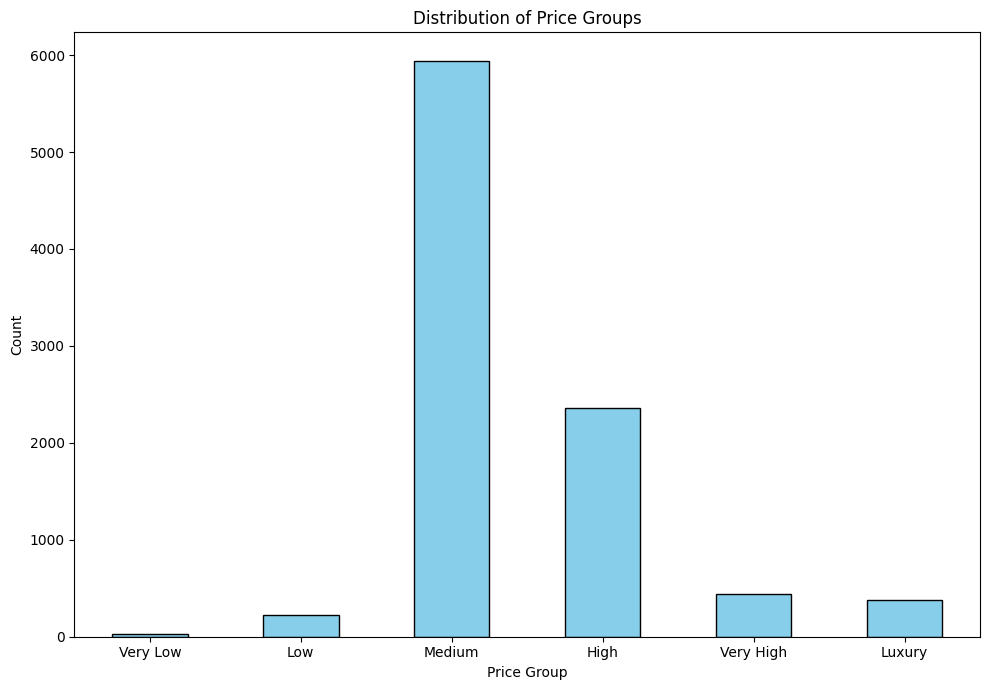

In [206]:
print(df['price'].describe())

# Define custom bins for more granular pricing
bins = [0, 3000, 10000, 25000, 50000, 100000, np.inf]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Luxury']

# Create a new column for price categories
df['price_group'] = pd.cut(df['price'], bins=bins, labels=labels, include_lowest=True)

# Count occurrences in each price group
price_counts = df['price_group'].value_counts()

# Plotting a bar chart for price group distribution
plt.figure(figsize=(10, 7))
price_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Price Groups')
plt.xlabel('Price Group')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.tight_layout()
plt.show()

In [207]:
# Identify extreme outliers (e.g., values above the 99th percentile)
threshold = df['price'].quantile(0.99)

# Remove extreme outliers from the DataFrame
df = df[df['price'] <= threshold]
df

,price,room_no,area_m2,age,floor,furniture,heating_type,fuel_type,monthly_fee,AGE_GROUP,floor_group,District,Neighborhood,price_group
0,25000,2 + 1,88.0,35.00000,1. Kat,Eşyalı Değil,Kombi,Doğalgaz,100.0,Very Old,First Floor,Karabağlar,Bahçelievler Mah.,Medium
1,25000,2 + 1,100.0,31.00000,4. Kat,Eşyalı Değil,Kombi,NaN,0.0,Very Old,Low Floor,Karşıyaka,Aksoy Mah.,Medium
2,18000,3 + 1,110.0,40.00000,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Very Old,Low Floor,Konak,Göztepe Mah.,Medium
3,25000,1 + 1,45.0,2.00000,Bahçe Katı,Eşyalı,Kombi,NaN,0.0,New,Ground Floor,Urla,Atatürk Mah.,Medium
4,20000,2 + 2,115.0,42.00000,2. Kat,NaN,Isıtma Yok,Elektrik,100.0,Very Old,Low Floor,Bayraklı,Mansuroğlu Mah.,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9349,21000,3 + 1,125.0,28.00000,3. Kat,Eşyalı Değil,Jeotermal Isıtma,NaN,150.0,Old,Low Floor,Balçova,Korutürk Mah.,Medium
9350,19000,2 + 1,120.0,20.00000,2. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Old,Low Floor,Bornova,Atatürk Mah.,Medium
9351,35000,4 + 1,226.0,5.00000,5. Kat,Eşyalı Değil,Merkezi (Pay Ölçer),NaN,250.0,New,Low Floor,Karşıyaka,Şemikler Mah.,High
9352,12000,1 + 1,55.0,16.84387,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Old,Low Floor,Menemen,İnönü Mah.,Medium


Drop the clients who are the extreme outliers to exclude them from the  calculations.

In [208]:
df = df.drop(columns=['price_group'])
df.head(5)

,price,room_no,area_m2,age,floor,furniture,heating_type,fuel_type,monthly_fee,AGE_GROUP,floor_group,District,Neighborhood
0,25000,2 + 1,88.0,35.0,1. Kat,Eşyalı Değil,Kombi,Doğalgaz,100.0,Very Old,First Floor,Karabağlar,Bahçelievler Mah.
1,25000,2 + 1,100.0,31.0,4. Kat,Eşyalı Değil,Kombi,NaN,0.0,Very Old,Low Floor,Karşıyaka,Aksoy Mah.
2,18000,3 + 1,110.0,40.0,3. Kat,Eşyalı Değil,Kombi,Doğalgaz,0.0,Very Old,Low Floor,Konak,Göztepe Mah.
3,25000,1 + 1,45.0,2.0,Bahçe Katı,Eşyalı,Kombi,NaN,0.0,New,Ground Floor,Urla,Atatürk Mah.
4,20000,2 + 2,115.0,42.0,2. Kat,NaN,Isıtma Yok,Elektrik,100.0,Very Old,Low Floor,Bayraklı,Mansuroğlu Mah.


Target = 1 represent clients with payment difficulties: he/she had late payment(s)

In [209]:
df.describe(include='object')

,room_no,floor,furniture,heating_type,fuel_type,AGE_GROUP,floor_group,District,Neighborhood
count,9261,9261,8654,9255,5417,9261,9261,9261,9261
unique,34,37,2,15,4,4,7,41,468
top,3 + 1,2. Kat,Eşyalı Değil,Kombi,Doğalgaz,Old,Low Floor,Buca,Atatürk Mah.
freq,3507,1622,5544,4843,3800,4053,4185,1252,490


In [210]:
numFeatures = len(df.columns)
numFeatures

13

In [211]:
numInstances = len(df)
numInstances

9261

In [212]:
le = LabelEncoder()
le_count = 0

df_copy = df.copy()

# Iterate through the columns
for col in df_copy:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            # Train on the training data
            le.fit(df[col])
            # Transform both training and testing data
            df[col] = le.transform(df[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


## DISTRIBUTION ANALYSIS

In this section we will observe relation between features of our dataset to better understand it. Such as the relation between the price and furniture, price and room_no, price and District of our listings.

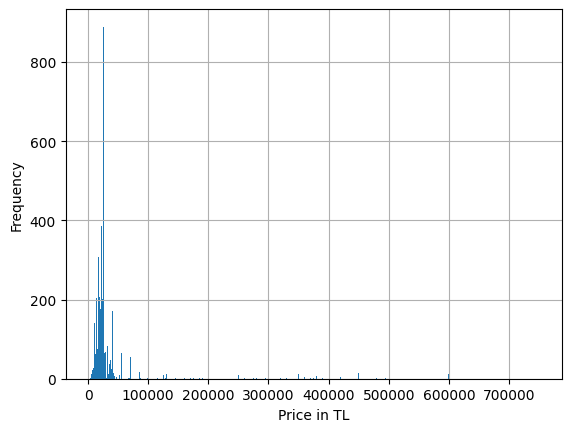

In [213]:
df['price'].hist(bins=1000)
plt.xlabel('Price in TL')
plt.ylabel('Frequency')
plt.show()

'price' column represents the Price of the property in TL

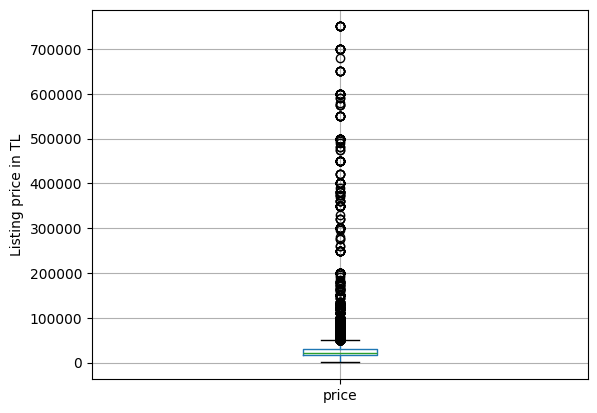

In [214]:
df.boxplot(column='price')
plt.ylabel('Listing price in TL')
plt.show()

In [215]:
# Quartile Ranges of listings prices
q1, q3 = np.percentile(df['price'], [25, 75])
iqr = q3 - q1
lower_bound = q1 - (iqr * 1.5)
upper_bound = q3 + (iqr * 1.5)
print("IQR: ", iqr)
print("Lower Bound: ", lower_bound)
print("Upper Bound: ", upper_bound)

IQR:  13000.0
Lower Bound:  -2500.0
Upper Bound:  49500.0


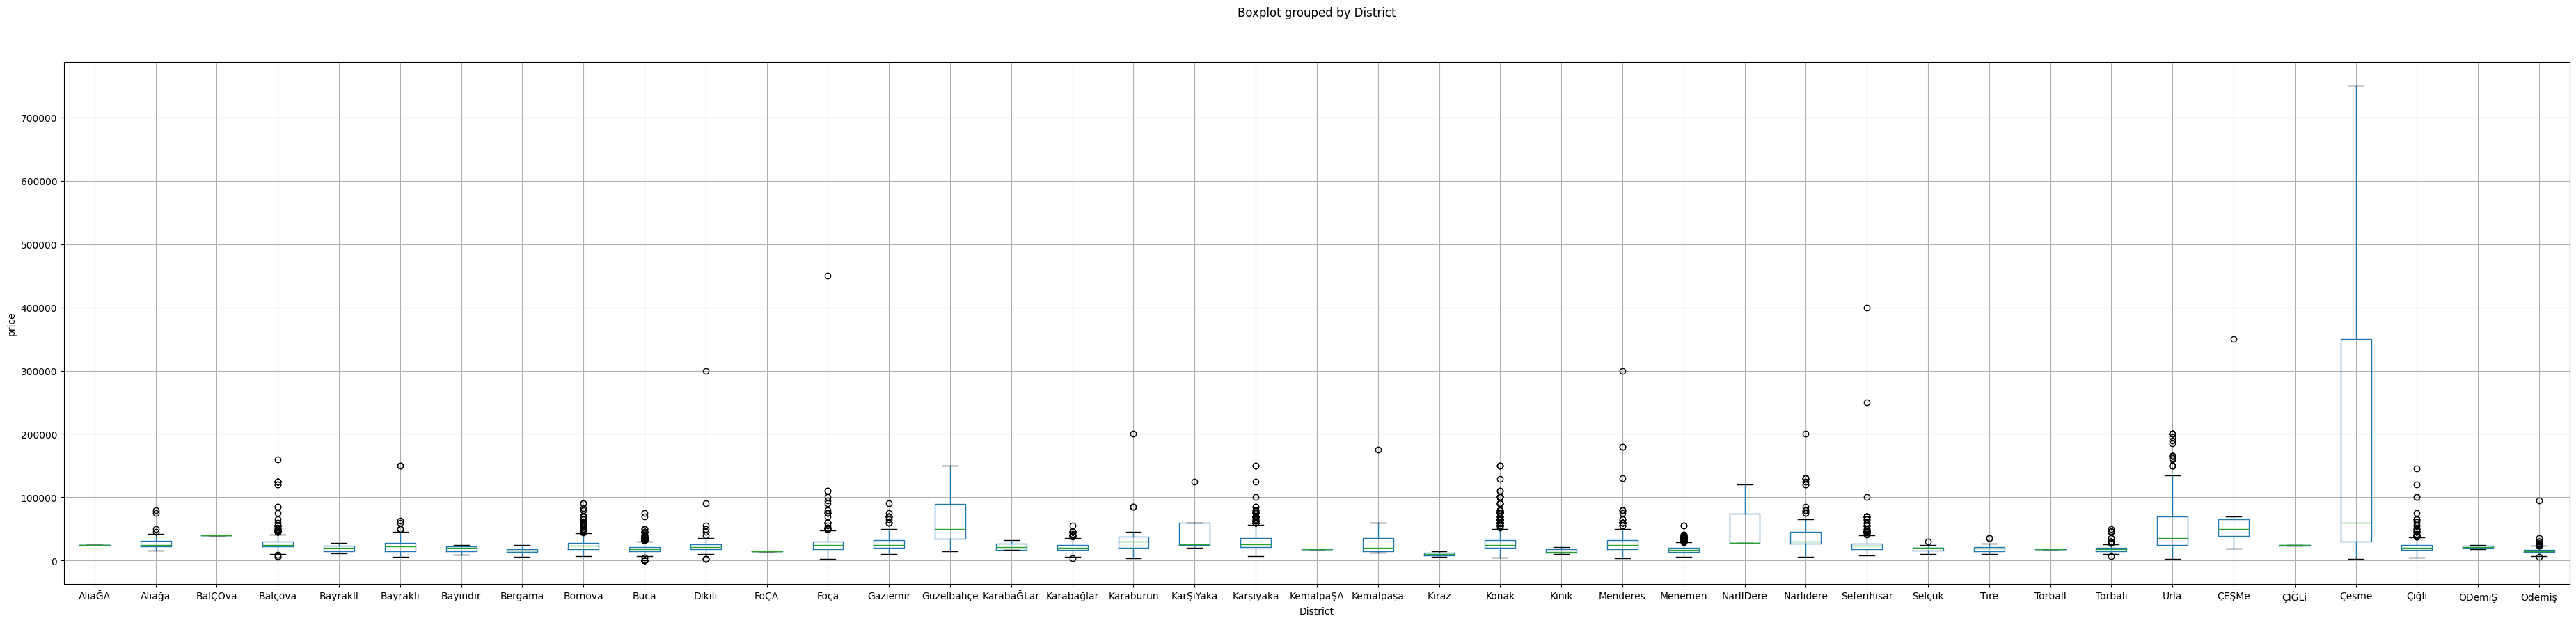

In [216]:
# Price grouped by districts types
boxplot = df.boxplot(column='price', by='District', figsize=(45, 10))
boxplot.set_xlabel('District', fontsize=10)
plt.ylabel('price')
plt.xlabel('District')
plt.title("")
plt.show()

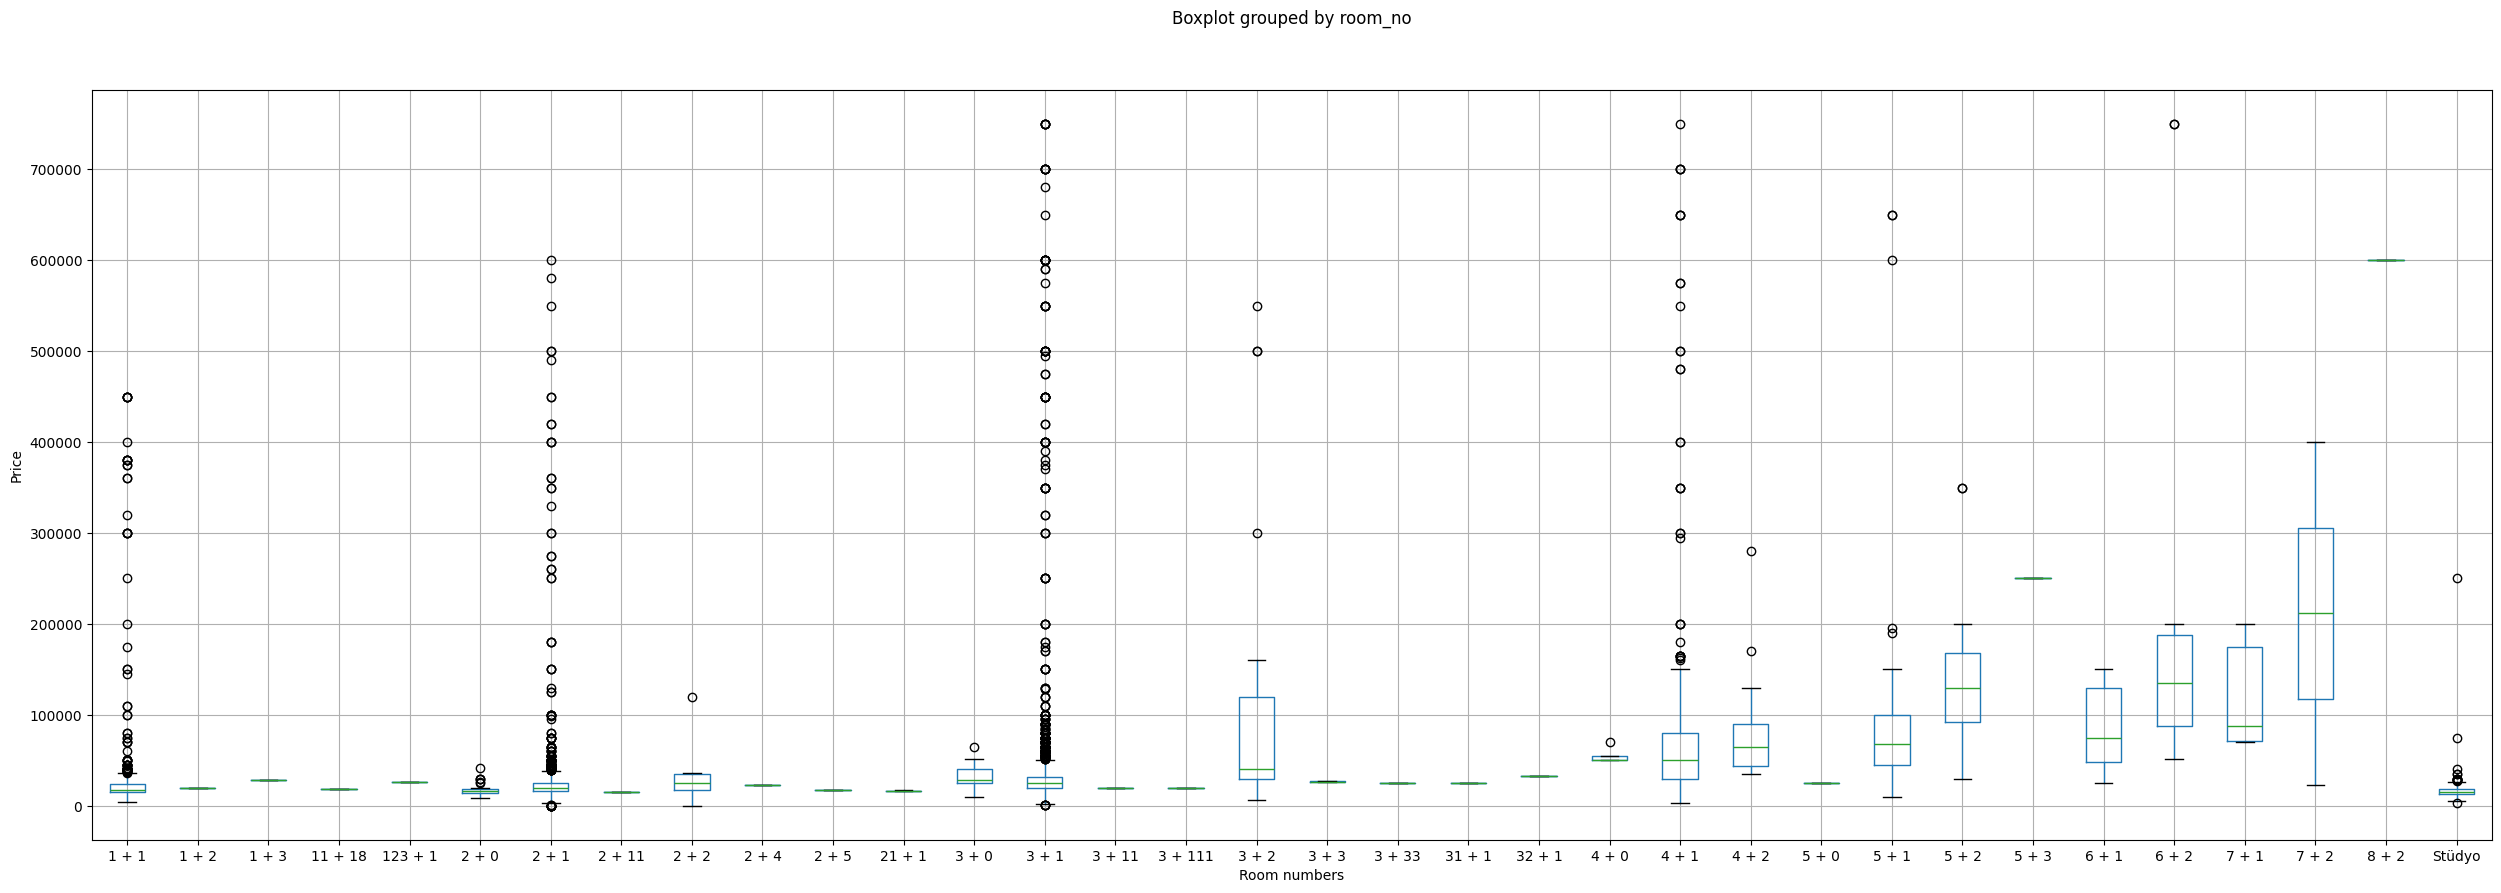

In [217]:
# Price grouped by Room numbers
boxplot = df.boxplot(column='price', by='room_no', figsize=(30, 10))
boxplot.set_xlabel('Room numbers', fontsize=10)
plt.ylabel('Price')
plt.xlabel('Room numbers')
plt.title("")
plt.show()

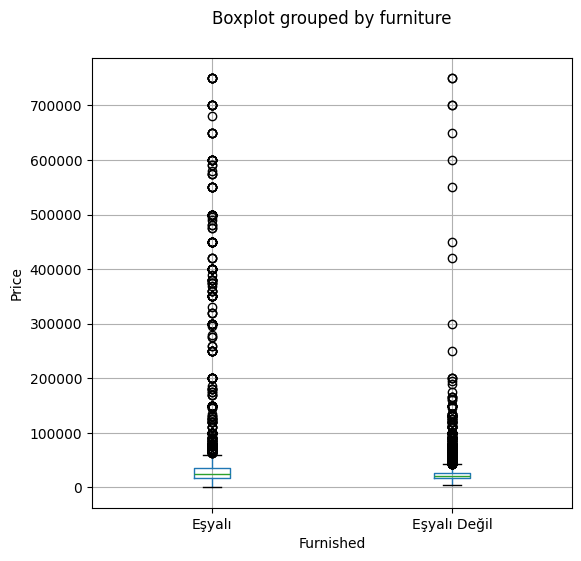

In [218]:
# Price grouped by furniture
boxplot = df.boxplot(column='price', by='furniture', figsize=(6, 6))
boxplot.set_xlabel('Furnished', fontsize=10)
plt.ylabel('Price')
plt.xlabel('Furnished')
plt.title("")
plt.show()

In [219]:
# Observing furniture frequences
temp1 = df['furniture'].value_counts(ascending=True)
print ('Frequency Table for wether the listing is furnished or not :')
print (temp1)

Frequency Table for wether the listing is furnished or not :
furniture
Eşyalı          3110
Eşyalı Değil    5544
Name: count, dtype: int64


In [220]:
# Filtering rows where 'furniture' is 'Eşyalı' and 'price' more than 50000 (high ,very high and luxurious)
filtered_data = df[(df['furniture'] == 'Eşyalı') & (df['price'] >= 50000)]

# Calculate the ratio
counter = len(filtered_data)
total_rows = len(df[df['price'] >= 50000])
ratio = counter / total_rows

print(f"The ratio of 'furniture' being 'Eşyalı' and probability of listing being  high ,very high and luxurious is: {ratio:.3%}")

The ratio of 'furniture' being 'Eşyalı' and probability of listing being  high ,very high and luxurious is: 53.865%


In [221]:
# Filter the DataFrame where 'price' >= 50000
filtered_data = df[df['price'] >= 50000]

# Calculate probability distributions for each 'furniture' category when 'price' is >= 50000
temp2 = filtered_data.pivot_table(values='price', index='furniture', aggfunc='count') / len(filtered_data)
print('\nProbability distributions for each furniture class where price is >= 50000:')
print(temp2)


Probability distributions for each furniture class where price is >= 50000:
                 price
furniture             
Eşyalı        0.538647
Eşyalı Değil  0.410628


<Axes: title={'center': 'Probability of getting a high, very high \n and luxurious listing by furniture status'}, xlabel='furniture', ylabel='Probability of having a high, very high \n and luxurious listing'>

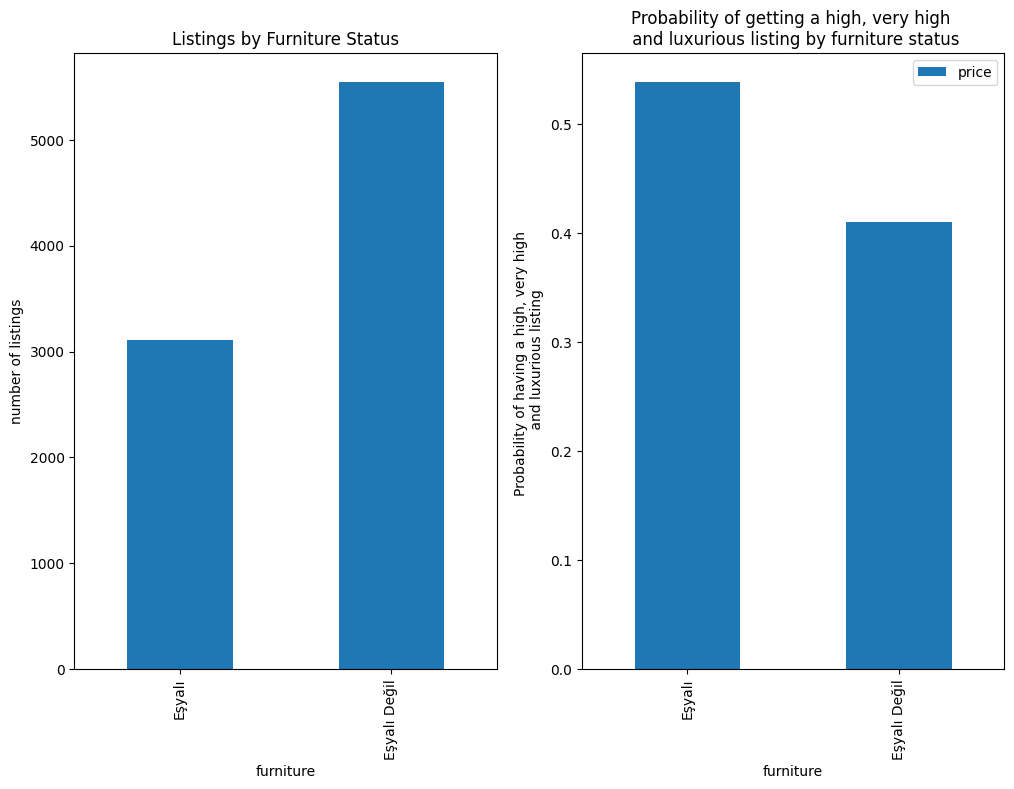

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(12,8))
ax1=axes[0]
ax1.set_xlabel('Furniture status')
ax1.set_ylabel('number of listings')
ax1.set_title("Listings by Furniture Status")
temp1.plot(kind='bar',ax=ax1)

ax2 = axes[1]
ax2.set_xlabel('Furniture Status')
ax2.set_ylabel('Probability of having a high, very high \n and luxurious listing')
ax2.set_title("Probability of getting a high, very high \n and luxurious listing by furniture status")
temp2.plot(kind = 'bar', ax = ax2)

# Deduct Most Important Features
---



In [223]:
categorical_feats = [
    f for f in df.columns if df[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    df[f_], _ = pd.factorize(df[f_])
    # Set feature type as categorical
    df[f_] = df[f_].astype('category')


In [224]:
print(categorical_feats)

['room_no', 'floor', 'furniture', 'heating_type', 'fuel_type', 'AGE_GROUP', 'floor_group', 'District', 'Neighborhood']


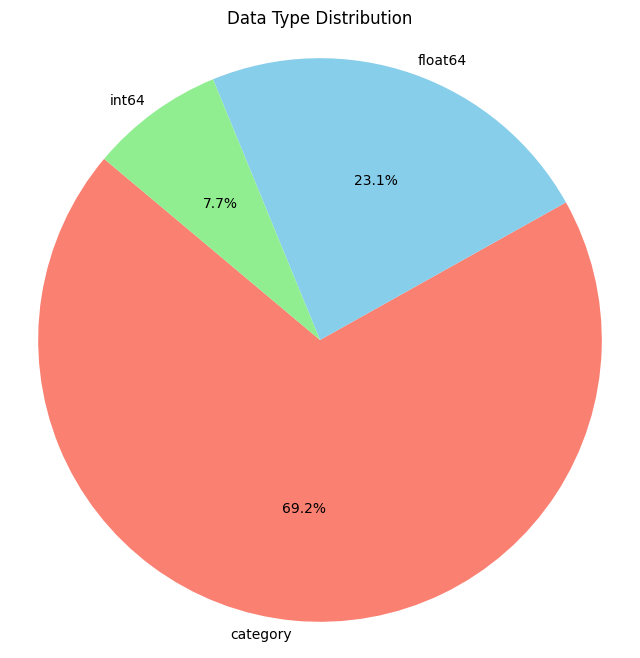

,price,room_no,area_m2,age,floor,furniture,heating_type,fuel_type,monthly_fee,AGE_GROUP,floor_group,District,Neighborhood
0,25000,0,88.0,35.00000,0,0,0,0,100.0,0,0,0,0
1,25000,0,100.0,31.00000,1,0,0,-1,0.0,0,1,1,1
2,18000,1,110.0,40.00000,2,0,0,0,0.0,0,1,2,2
3,25000,2,45.0,2.00000,3,1,0,-1,0.0,1,2,3,3
4,20000,3,115.0,42.00000,4,-1,1,1,100.0,0,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9349,21000,1,125.0,28.00000,2,0,7,-1,150.0,3,1,13,96
9350,19000,0,120.0,20.00000,4,0,0,0,0.0,3,1,6,3
9351,35000,4,226.0,5.00000,8,0,5,-1,250.0,1,1,1,51
9352,12000,2,55.0,16.84387,2,0,0,0,0.0,3,1,20,24


In [225]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame
# Replace this with the actual data types of your DataFrame columns
data_types = df.dtypes

# Replace 'category' data types with a single category name 'category'
data_types = data_types.replace('category', 'category')

# Count the occurrences of each data type
data_type_counts = data_types.value_counts()

# Dictionary to map data types to colors
color_dict = {
    'int64': 'lightgreen',
    'float64': 'skyblue',
    'category': 'salmon',  # Grouped category color
    # Add other data types and colors if needed
}

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Create a pie chart
wedges, texts, autotexts = ax.pie(data_type_counts, labels=data_type_counts.index,
                                  colors=[color_dict.get(str(dt), 'gray') for dt in data_type_counts.index],
                                  autopct='%1.1f%%', startangle=140, labeldistance=1.05)  # Adjust label distance here

plt.setp(autotexts, size=10)  # Set size for autopct labels

plt.title('Data Type Distribution')

# Show plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

df


In [226]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['price']]
    feature_data_types = data[train_features].dtypes.reset_index()
    feature_data_types.columns = ['feature', 'data_type']

    # Shuffle target if required
    y = data['price'].copy()
    if shuffle:
        y = data['price'].copy().sample(frac=1.0)

    # Fit LightGBM in regression mode
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False)

    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'seed': seed,
        'n_jobs': -1
    }

    # Train the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=[])

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df = pd.merge(imp_df, feature_data_types, on='feature', how='left')

    return imp_df

Importance split measures how frequently a feature is used for making splits in decision trees.
Importance gain measures the contribution of a feature to the model's performance improvement during the splitting process.

In [227]:
df['furniture'] = df['furniture'].astype('category')  # Set as categorical# Usage
print(df[['furniture', 'price']].groupby('furniture').mean())  # Check target mean per category
np.random.seed(123)
# Get the actual importance, i.e., without shuffling
actual_imp_df = get_feature_importances(data=df, shuffle=False)

sorted_by_gain = actual_imp_df.sort_values(by='importance_gain', ascending=False)

# Sort the DataFrame by 'importance_split' column in descending order
sorted_by_split = actual_imp_df.sort_values(by='importance_split', ascending=False)

print(sorted_by_gain)
print(sorted_by_split)

<ipython-input-227-0d9816fa8a0c>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df[['furniture', 'price']].groupby('furniture').mean())  # Check target mean per category
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")


                  price
furniture              
-1         26928.518946
 0         26271.246573
 1         49888.914148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 9261, number of used features: 12
[LightGBM] [Info] Start training from score 34245.537739
         feature  importance_gain  importance_split data_type
10      District     1.029569e+14               748  category
1        area_m2     6.193738e+13              1365   float64
11  Neighborhood     4.152754e+13               936  category
2            age     2.518570e+13               690   float64
3          floor     1.739739e+13               395  category
5   heating_type     1.739258e+13               535  category
4      furniture     8.493490e+12               161  category
6      fuel_type     8.319806e+12       

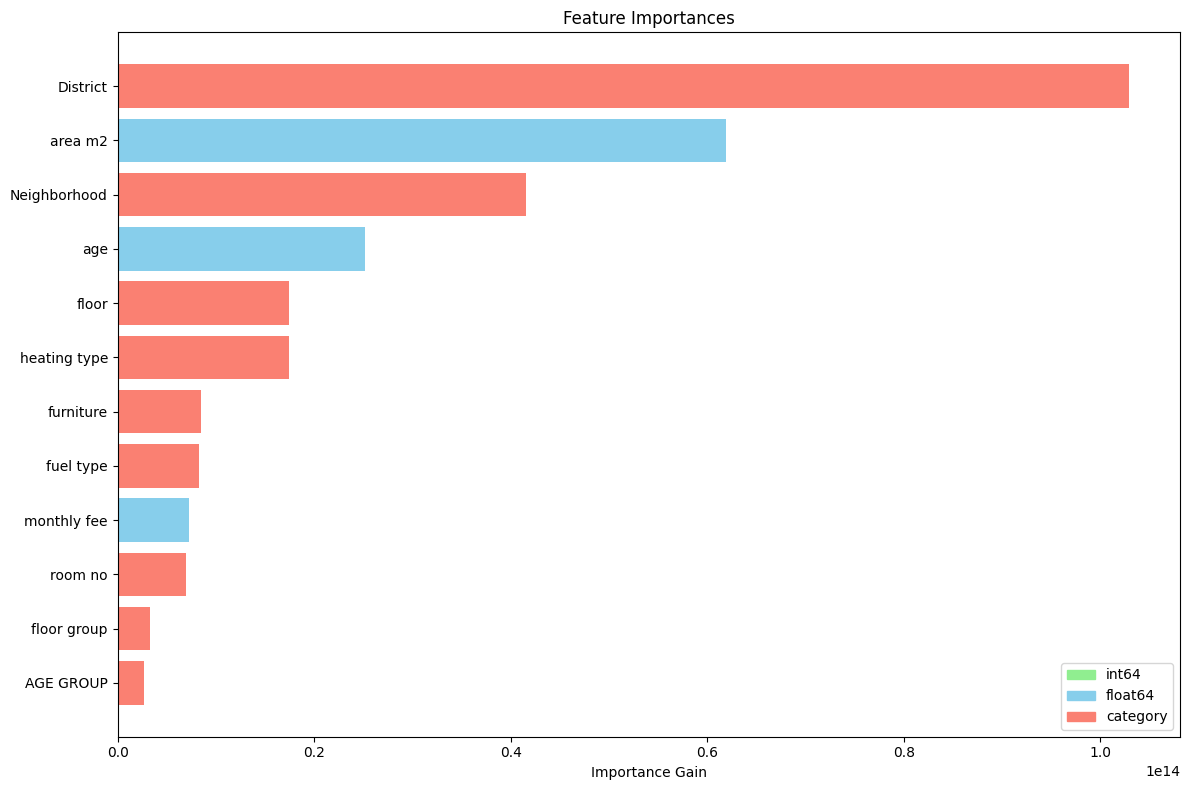

In [228]:
import matplotlib.pyplot as plt

# Your data
feature_names = sorted_by_gain['feature']
importance_gain = sorted_by_gain['importance_gain']
data_types = sorted_by_gain['data_type']

# Dictionary to map data types to colors
color_dict = {
    'int64': 'lightgreen',
    'float64': 'skyblue',
    'category': 'salmon'
}

# Convert data types to strings for consistent handling
data_types = data_types.astype(str)

# Extracting colors based on data types
colors = [color_dict[data_type] for data_type in data_types]

# Replace underscores with spaces in feature names
feature_names = [name.replace('_', ' ') for name in feature_names]

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_names, importance_gain, color=colors)
plt.xlabel('Importance Gain')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top

# Creating a legend for data types
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_dict[data_type]) for data_type in color_dict]
plt.legend(legend_handles, color_dict.keys())

plt.tight_layout()

# Show plot
plt.show()


# Data preprocessing & Trainning

In [229]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = df[(df['price'] >= 15000) & (df['price'] <= 100000)]

# Define features (X) and target (y)
X = df.drop(columns=['price'])  # Remove target column
y = df['price']


# One-hot encoding for categorical features
X = pd.get_dummies(X, drop_first=True)

# Scale numerical features (optional, especially for models like SVR, Neural Networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Linear Regression

In [230]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

# GCV for Linear Regression
n_lr = len(y_test)
trace_h_lr = X_train.shape[1]  # Number of features
lr_gcv = (n_lr * lr_mse) / ((n_lr - trace_h_lr) ** 2)

print(f"Linear Regression - RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}, R²: {lr_r2:.2f}, GCV: {lr_gcv:.2f}")


Linear Regression - RMSE: 8505.31, MAE: 5248.93, R²: 0.66, GCV: 119519.61


Ridge regularisation Linear Regression

In [231]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_model = Ridge()
ridge_cv = GridSearchCV(ridge_model, params, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

print("Best alpha:", ridge_cv.best_params_)
best_ridge = ridge_cv.best_estimator_

# Evaluate on test set
y_pred_ridge = best_ridge.predict(X_test)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("Ridge R^2:", ridge_r2)


Best alpha: {'alpha': 100}
Ridge R^2: 0.6644310824836966


# Decision Treee Regression

In [242]:
from sklearn.tree import DecisionTreeRegressor

# Train Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt_model.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

# GCV for Decision Tree
n_dt = len(y_test)
trace_h_dt = len(dt_model.tree_.feature)  # Number of splits
dt_gcv = (n_dt * mean_squared_error(y_test, y_pred_dt)) / ((n_dt - trace_h_dt) ** 2)

print(f"Decision Tree - RMSE: {dt_rmse:.2f}, MAE: {dt_mae:.2f}, R²: {dt_r2:.2f}, GCV: {dt_gcv:.2f}")


Decision Tree - RMSE: 8694.91, MAE: 4504.90, R²: 0.65, GCV: 2588.18


# Random Forest Regression:

In [236]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# GCV for Random Forest
n_rf = len(y_test)
trace_h_rf = rf_model.n_estimators  # Number of trees
rf_gcv = (n_rf * mean_squared_error(y_test, y_pred_rf)) / ((n_rf - trace_h_rf) ** 2)

print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}, R²: {rf_r2:.2f}, GCV: {rf_gcv:.2f}")


Random Forest - RMSE: 7276.75, MAE: 4021.43, R²: 0.75, GCV: 37922.67


# Gradient boosting

In [240]:
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

# GCV for Gradient Boosting
n_gb = len(y_test)
trace_h_gb = gb_model.n_estimators  # Number of trees
gb_gcv = (n_gb * mean_squared_error(y_test, y_pred_gb)) / ((n_gb - trace_h_gb) ** 2)

print(f"Gradient Boosting - RMSE: {gb_rmse:.2f}, MAE: {gb_mae:.2f}, R²: {gb_r2:.2f}, GCV: {gb_gcv:.2f}")


Gradient Boosting - RMSE: 8528.91, MAE: 5457.63, R²: 0.66, GCV: 52096.86


# SVM


In [243]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Log-transform the target variable
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning with RandomizedSearchCV
param_grid = {'C': [1, 10], 'epsilon': [0.1, 0.5], 'kernel': ['rbf']}
random_search = RandomizedSearchCV(SVR(), param_distributions=param_grid, n_iter=5, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(X_train_scaled, y_train_log)

svr_model = random_search.best_estimator_
svr_model.fit(X_train_scaled, y_train_log)

# Predict and reverse log-transform
y_pred_log = svr_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
svr_mae = mean_absolute_error(y_test, y_pred)
svr_r2 = r2_score(y_test, y_pred)

# GCV for SVR
n_svr = len(y_test)
trace_h_svr = len(svr_model.support_)  # Number of support vectors
svr_gcv = (n_svr * mean_squared_error(y_test, y_pred)) / ((n_svr - trace_h_svr) ** 2)

print(f"SVR - RMSE: {svr_rmse:.2f}, MAE: {svr_mae:.2f}, R²: {svr_r2:.2f}, GCV: {svr_gcv:.2f}")


SVR - RMSE: 8874.59, MAE: 4791.32, R²: 0.63, GCV: 36787.54


# Neural network


In [244]:
from sklearn.neural_network import MLPRegressor

# Train Neural Network
nn_model = MLPRegressor(random_state=42, max_iter=1000)
nn_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_nn = nn_model.predict(X_test_scaled)
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_r2 = r2_score(y_test, y_pred_nn)

# GCV for Neural Network
n_nn = len(y_test)
trace_h_nn = len(nn_model.coefs_)  # Approximation based on layers
nn_gcv = (n_nn * mean_squared_error(y_test, y_pred_nn)) / ((n_nn - trace_h_nn) ** 2)

print(f"Neural Network - RMSE: {nn_rmse:.2f}, MAE: {nn_mae:.2f}, R²: {nn_r2:.2f}, GCV: {nn_gcv:.2f}")


Neural Network - RMSE: 7961.08, MAE: 4719.30, R²: 0.70, GCV: 39961.38


# Summary of all models before cross validation

In [245]:
import pandas as pd

# Create a summary DataFrame
results = [
    {"Model": "Linear Regression", "RMSE": lr_rmse, "MAE": lr_mae, "R²": lr_r2, "GCV": lr_gcv},
    {"Model": "Decision Tree", "RMSE": dt_rmse, "MAE": dt_mae, "R²": dt_r2, "GCV": dt_gcv},
    {"Model": "Random Forest", "RMSE": rf_rmse, "MAE": rf_mae, "R²": rf_r2, "GCV": rf_gcv},
    {"Model": "Gradient Boosting", "RMSE": gb_rmse, "MAE": gb_mae, "R²": gb_r2, "GCV": gb_gcv},
    {"Model": "Support Vector Regression", "RMSE": svr_rmse, "MAE": svr_mae, "R²": svr_r2, "GCV": svr_gcv},
    {"Model": "Neural Network", "RMSE": nn_rmse, "MAE": nn_mae, "R²": nn_r2, "GCV": nn_gcv},
]

results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)



Summary of Results:
                       Model         RMSE          MAE        R²  \
0          Linear Regression  8505.307773  5248.929621  0.662194   
1              Decision Tree  8694.907283  4504.903145  0.646965   
2              Random Forest  7276.745148  4021.433146  0.752735   
3          Gradient Boosting  8528.909029  5457.629731  0.660316   
4  Support Vector Regression  8874.588072  4791.317386  0.632224   
5             Neural Network  7961.083860  4719.299938  0.704041   

             GCV  
0  119519.612611  
1    2588.184992  
2   37922.670923  
3   52096.860444  
4   36787.543680  
5   39961.384424  


# K-Fold Setup

In [246]:
import numpy as np
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------------
# K-Fold configuration
# ---------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# A helper function to compute metrics and (optionally) approximate GCV
def cross_val_metrics(model, X_data, y_data, kf, model_name=""):
    """
    Returns dict of { 'rmse', 'mae', 'r2', 'gcv' }
    using cross_val_predict and cross_val_score.
    """
    # 1) Out-of-fold predictions across entire training set
    cv_preds = cross_val_predict(model, X_data, y_data, cv=kf, n_jobs=-1)

    # 2) Cross_val_score to get MSE (neg_mean_squared_error)
    cv_mse_scores = cross_val_score(
        model, X_data, y_data,
        cv=kf, scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # A) RMSE (averaging MSE across folds)
    rmse = np.sqrt(-np.mean(cv_mse_scores))

    # B) MAE
    mae = mean_absolute_error(y_data, cv_preds)

    # C) R^2
    r2 = r2_score(y_data, cv_preds)

    # D) Approx. GCV
    # For linear regression: trace_h = X_data.shape[1]
    # For others (Decision Tree, RandomForest, etc.), adapt as needed
    n = len(y_data)
    # We'll compute MSE on all OOF predictions:
    mse_full = mean_squared_error(y_data, cv_preds)
    # Example: just use #features as a naive "trace_h"
    trace_h = X_data.shape[1]

    # If you'd like to replicate your original approximations:
    #  DecisionTree: trace_h = len(model.tree_.feature)  # BUT model is refit multiple times in CV
    #  RandomForest: trace_h = model.n_estimators
    # etc. That is tricky with cross-validation because the model is re-fit in each fold.
    # We'll just show a simple approach using # of features to keep consistent with LinearRegression logic.
    gcv = (n * mse_full) / ((n - trace_h) ** 2) if n > trace_h else np.nan

    return {
        "Model": model_name,
        "RMSE (CV)": rmse,
        "MAE (CV)": mae,
        "R² (CV)": r2,
        "GCV (Approx)": gcv
    }


# linear regression with 5-fold crossvaliation

In [247]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize Linear Regression model
lr_model = LinearRegression()

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Perform cross-validation and predictions
cv_predictions = cross_val_predict(lr_model, X_train, y_train, cv=kf)
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Calculate metrics
lr_rmse = np.sqrt(-np.mean(cv_scores))  # Average RMSE across folds
lr_mae = mean_absolute_error(y_train, cv_predictions)
lr_r2 = r2_score(y_train, cv_predictions)

# Calculate GCV
n_lr = len(y_train)
trace_h_lr = X_train.shape[1]  # Number of features
lr_mse = mean_squared_error(y_train, cv_predictions)
lr_gcv = (n_lr * lr_mse) / ((n_lr - trace_h_lr) ** 2)

# Print metrics
print(f"Linear Regression (Cross-Validation) - RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}, R²: {lr_r2:.2f}, GCV: {lr_gcv:.2f}")


Linear Regression (Cross-Validation) - RMSE: 8523.96, MAE: 5288.04, R²: 0.59, GCV: 13971.84


# Decision Tree Crossfold

In [248]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_results_cv = cross_val_metrics(dt_model, X_train, y_train, kf, model_name="Decision Tree")
print(dt_results_cv)


{'Model': 'Decision Tree', 'RMSE (CV)': 9334.503419696763, 'MAE (CV)': 4775.3495283018865, 'R² (CV)': 0.5057316614162846, 'GCV (Approx)': 16755.323555418112}


# Random Forest Crossfold

In [249]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_results_cv = cross_val_metrics(rf_model, X_train, y_train, kf, model_name="Random Forest")
print(rf_results_cv)


{'Model': 'Random Forest', 'RMSE (CV)': 7162.068691095671, 'MAE (CV)': 4139.594492885783, 'R² (CV)': 0.7090239008501844, 'GCV (Approx)': 9863.870103674102}


# Gradient Boosting with 5-Fold CV

In [250]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)
gb_results_cv = cross_val_metrics(gb_model, X_train, y_train, kf, model_name="Gradient Boosting")
print(gb_results_cv)


{'Model': 'Gradient Boosting', 'RMSE (CV)': 8150.549472475646, 'MAE (CV)': 5259.321983360767, 'R² (CV)': 0.6231624868401779, 'GCV (Approx)': 12774.507221935937}


# SVR with 5-Fold CV

In [251]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# SVR model
svr_model_final = SVR(C=1, epsilon=0.1, kernel='rbf')  # Example

# Cross-validation predictions in log space
svr_cv_preds_log = cross_val_predict(svr_model_final, X_train_scaled, y_train_log, cv=kf, n_jobs=-1)

# Convert predictions back to the original scale
svr_cv_preds = np.expm1(svr_cv_preds_log)

# Evaluate metrics on the original scale
svr_rmse_cv = np.sqrt(mean_squared_error(y_train, svr_cv_preds))
svr_mae_cv = mean_absolute_error(y_train, svr_cv_preds)
svr_r2_cv = r2_score(y_train, svr_cv_preds)

# Compile results into a dictionary for clarity
sv_results_cv = {
    "Model Name": "SVM",
    "RMSE (CV)": svr_rmse_cv,
    "MAE (CV)": svr_mae_cv,
    "R2 (CV)": svr_r2_cv
}

# Print results
print(sv_results_cv)


{'Model Name': 'SVM', 'RMSE (CV)': 8222.559197249335, 'MAE (CV)': 4566.993651513993, 'R2 (CV)': 0.616474388523645}


# Neural Network 5 CV

In [252]:
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(random_state=42, max_iter=1000)

nn_results_cv = cross_val_metrics(nn_model, X_train_scaled, y_train, kf, model_name="Neural Network")
print(nn_results_cv)


{'Model': 'Neural Network', 'RMSE (CV)': 9082.847288463872, 'MAE (CV)': 5242.1455857905175, 'R² (CV)': 0.5320231410072693, 'GCV (Approx)': 15864.06224468981}


# Plot results

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

def plot_model_performance(model, X_train, y_train, X_test, y_test, cv=5, model_name=""):
    """
    Train the given model on (X_train, y_train), predict on X_test,
    then also use cross_val_predict on the training set to compare
    "before vs. after cross-validation" results.

    Generates:
      - Predicted vs Actual plot (train/test)
      - Residual plot (train/test)
      - Predicted vs Actual plot (cross-val)
      - Residual plot (cross-val)
    """
    # ---------------------------
    # 1. SINGLE TRAIN/TEST PREDICTIONS
    # ---------------------------
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # ---------------------------
    # 2. CROSS-VALIDATION PREDICTIONS
    # ---------------------------
    # cross_val_predict returns out-of-fold predictions for each point in X_train
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1)

    # ---------------------------
    # 3. PLOTS SETUP
    # ---------------------------
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"{model_name}", fontsize=16, y=1.02)

    # --------------------------------------------------
    # A) SINGLE TRAIN/TEST — Predicted vs Actual
    # --------------------------------------------------
    axs[0, 0].scatter(y_test, y_pred_test, alpha=0.3)
    axs[0, 0].set_title("Train/Test: Actual vs. Predicted")
    axs[0, 0].set_xlabel("Actual Values")
    axs[0, 0].set_ylabel("Predicted Values")
    # Diagonal reference line
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    axs[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--')

    # --------------------------------------------------
    # B) SINGLE TRAIN/TEST — Residual Plot
    # --------------------------------------------------
    residuals_test = y_test - y_pred_test
    axs[1, 0].scatter(y_pred_test, residuals_test, alpha=0.3)
    axs[1, 0].set_title("Train/Test: Residual Plot")
    axs[1, 0].set_xlabel("Predicted Values")
    axs[1, 0].set_ylabel("Residuals")
    axs[1, 0].axhline(y=0, color='r', linestyle='--')

    # --------------------------------------------------
    # C) CROSS-VALIDATION — Predicted vs Actual
    # --------------------------------------------------
    axs[0, 1].scatter(y_train, y_pred_cv, alpha=0.3, color='green')
    axs[0, 1].set_title(f"{cv}-Fold CV: Actual vs. Predicted")
    axs[0, 1].set_xlabel("Actual Values")
    axs[0, 1].set_ylabel("Predicted Values")
    # Diagonal reference line
    min_val_cv = min(y_train.min(), y_pred_cv.min())
    max_val_cv = max(y_train.max(), y_pred_cv.max())
    axs[0, 1].plot([min_val_cv, max_val_cv], [min_val_cv, max_val_cv], 'r--')

    # --------------------------------------------------
    # D) CROSS-VALIDATION — Residual Plot
    # --------------------------------------------------
    residuals_cv = y_train - y_pred_cv
    axs[1, 1].scatter(y_pred_cv, residuals_cv, alpha=0.3, color='green')
    axs[1, 1].set_title(f"{cv}-Fold CV: Residual Plot")
    axs[1, 1].set_xlabel("Predicted Values")
    axs[1, 1].set_ylabel("Residuals")
    axs[1, 1].axhline(y=0, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()


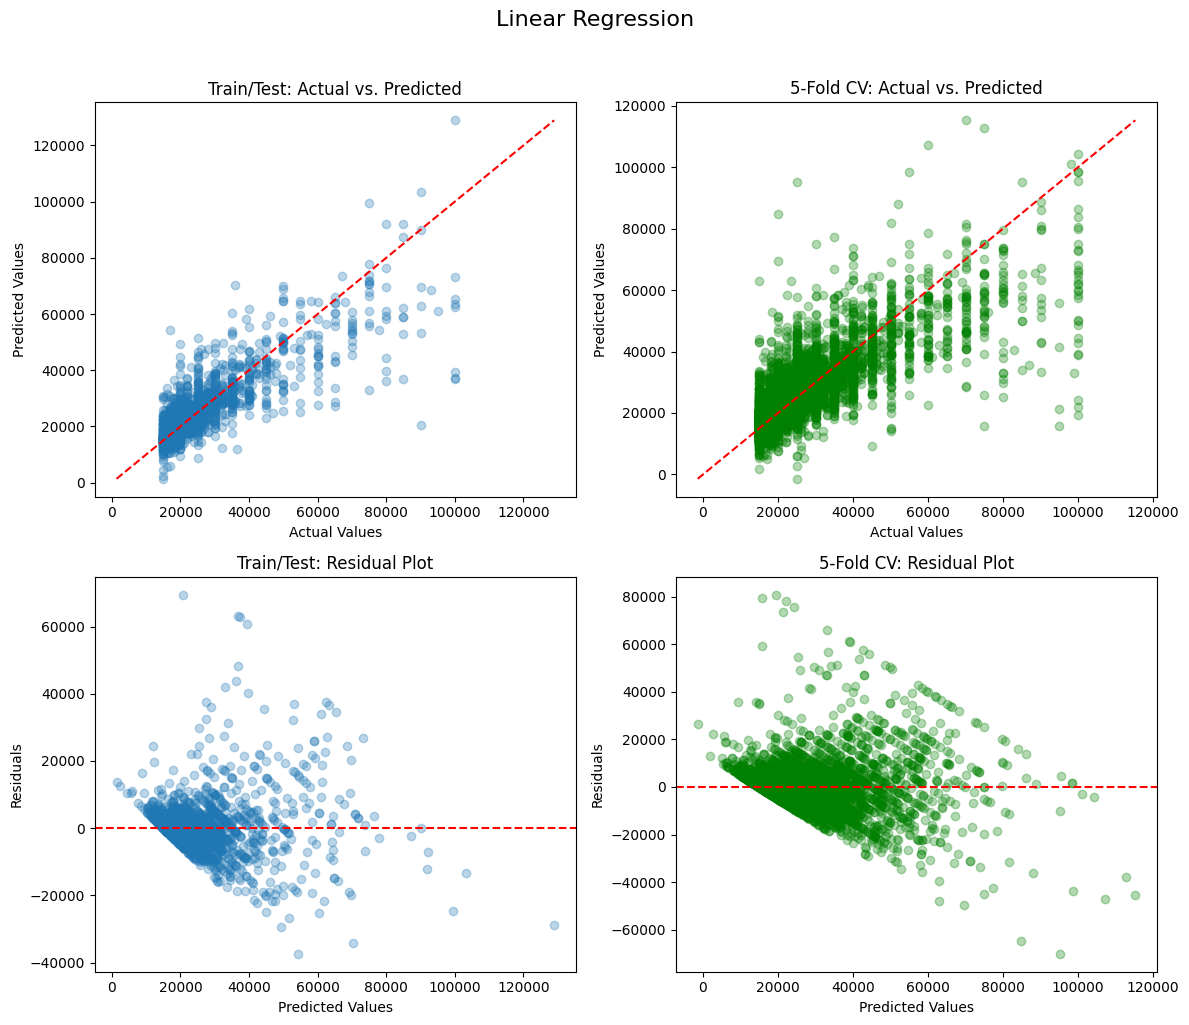

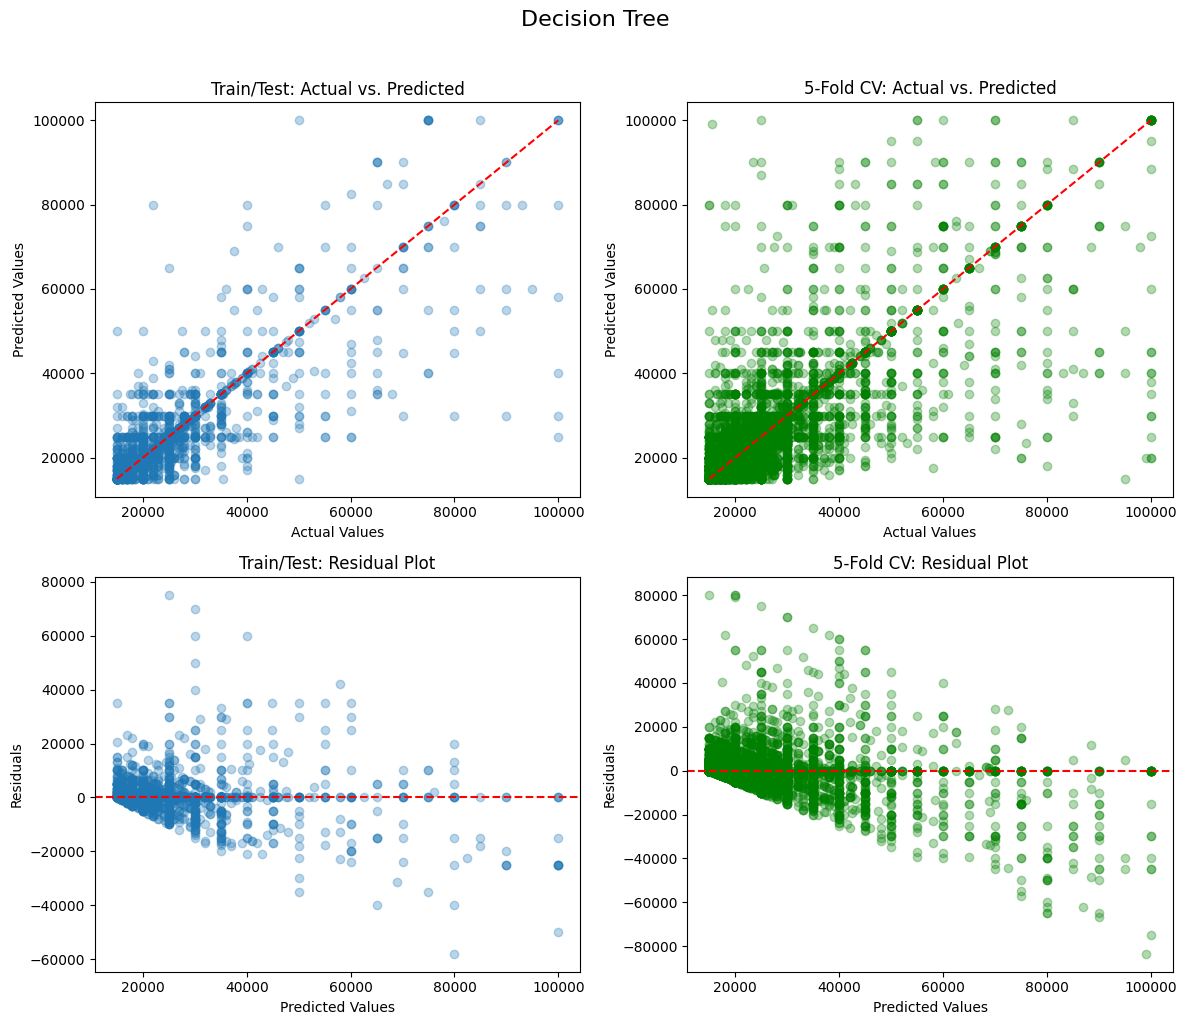

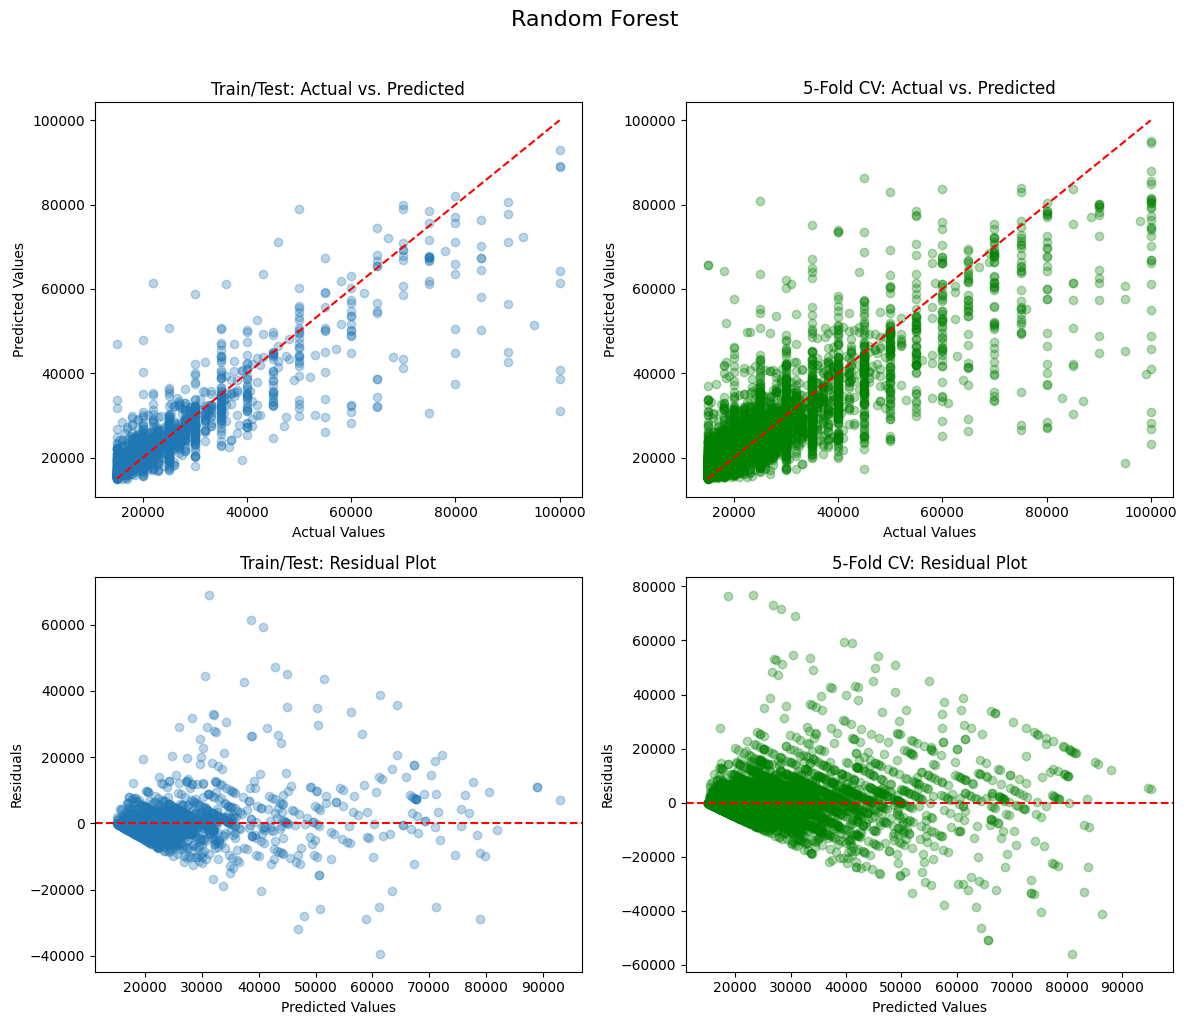

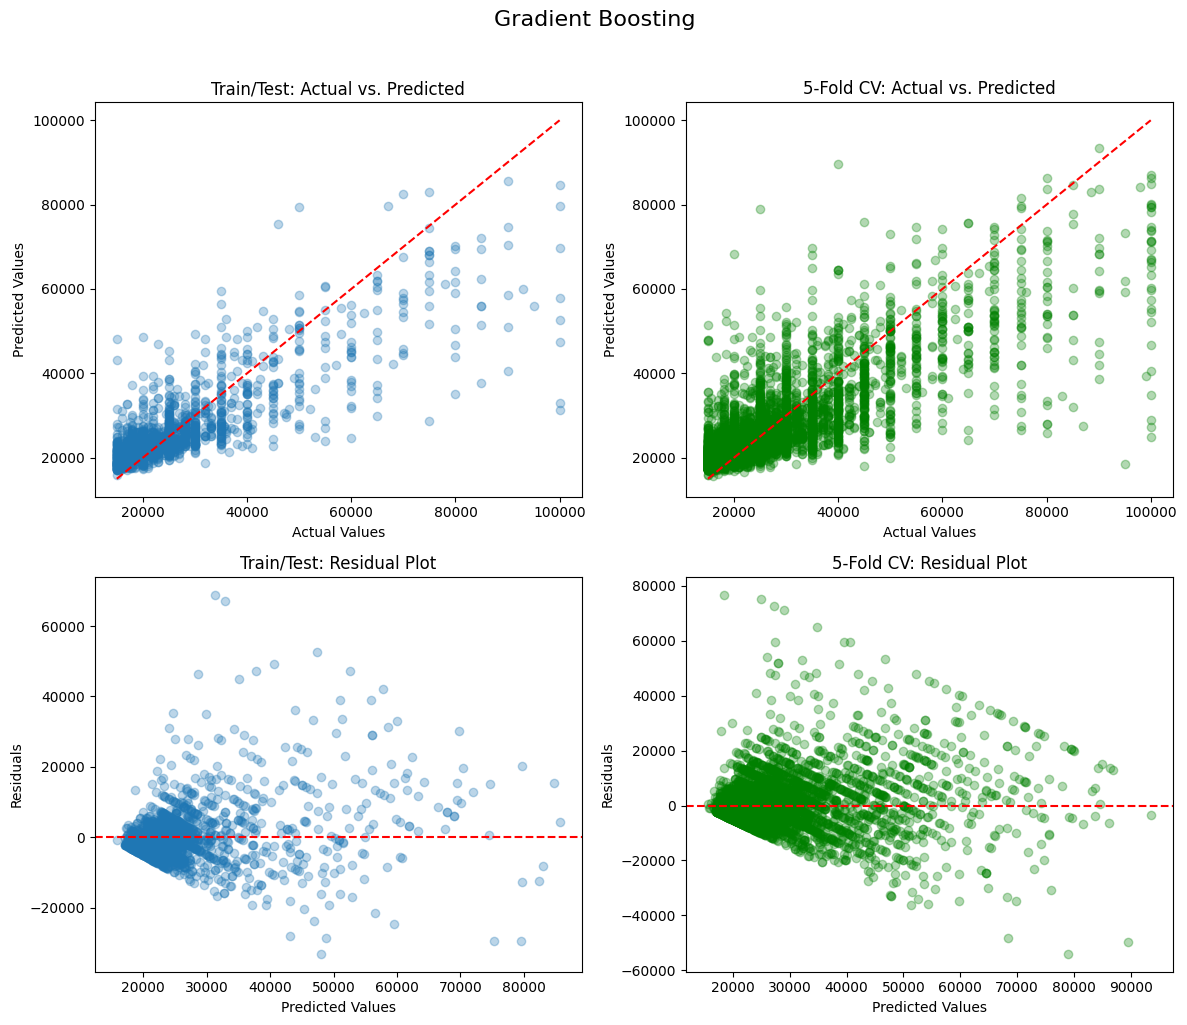

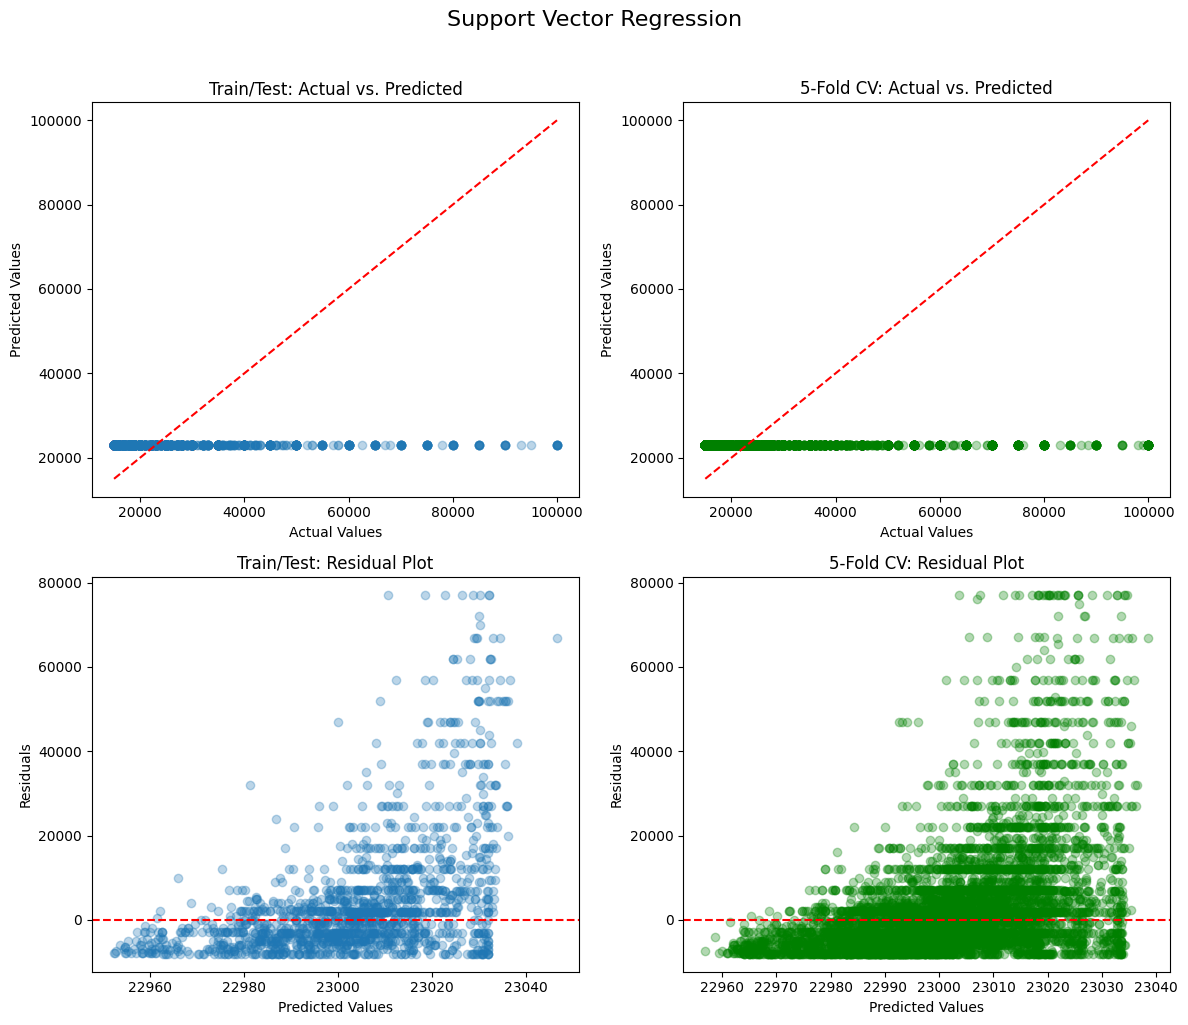

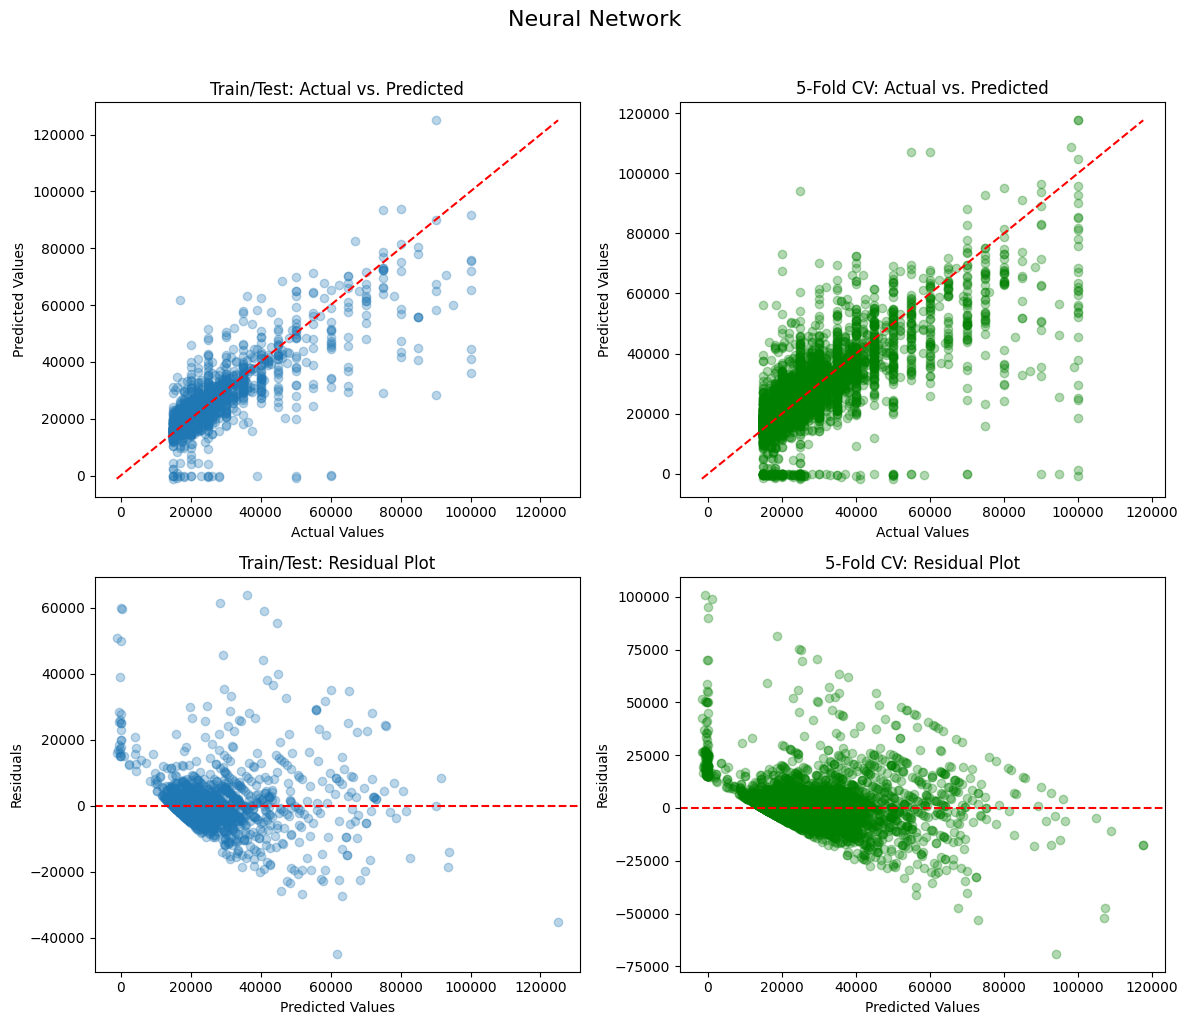

In [254]:
# Example usage for LinearRegression
plot_model_performance(
    lr_model,         # your trained model instance (or untrained, function fits it)
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,             # or any n_splits you prefer
    model_name="Linear Regression"
)

# Decision Tree
plot_model_performance(
    dt_model,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    model_name="Decision Tree"
)

# Random Forest
plot_model_performance(
    rf_model,
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    model_name="Random Forest"
)

# --- 2.4 Gradient Boosting ---
gb_model = GradientBoostingRegressor(random_state=42)
plot_model_performance(
    gb_model,
    X_train, y_train,
    X_test, y_test,
    cv=5,
    model_name="Gradient Boosting"
)

# --- 2.5 SVM ---
svr_model = SVR()
plot_model_performance(
    svr_model,
    X_train, y_train,
    X_test, y_test,
    cv=5,
    model_name="Support Vector Regression"
)

# --- 2.6 Neural Network ---
nn_model = MLPRegressor(random_state=42, max_iter=1000)
plot_model_performance(
    nn_model,
    X_train, y_train,
    X_test, y_test,
    cv=5,
    model_name="Neural Network"
)